In [1]:
import sys
sys.path.append('/home/xinyiz/pamrats')

In [33]:
import time
import os

import scanpy
import numpy as np
import scipy.sparse as sp

import torch
from torch import optim
from torch.utils.data import DataLoader

import image.loadImage as loadImage
import gae.gae.optimizer as optimizer
import gae.gae.model
import gae.gae.preprocessing as preprocessing
import image.modelsCNN as modelsCNN

import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib.colors
from sklearn.preprocessing import MinMaxScaler
import anndata as ad

from venn import venn


In [3]:
imageSizes={}
imageSizes['disease13']=(22210, 22344)
imageSizes['control13']=(22355, 18953)
imageSizes['disease8']=(22294, 19552)
imageSizes['control8']=(22452, 19616)

plaqueMaskName='PlaqueMask6'
plaqueMaskImg='Maskofplaque6.tif'
lossThreshSize=1111

In [29]:
# name='allk20XA_02_dca_over_leiden0.05_epoch9990'
# gaeClusterPath='/mnt/external_ssd/xinyi/plots/train_gae_starmap/allk20XA_02_dca_over/combinedlogminmax_beforeAct/cluster/leiden_nn10mdist025n_pcs40res0.05epoch9990'
name='all'
gaeClusterPath=None

desavepath='/mnt/external_ssd/xinyi/plots/data/plaqueDE/'+name
diamThresh_mul=800
minThresh_mul=12
overlap=int(diamThresh_mul*0.7)
areaThresh=diamThresh_mul*diamThresh_mul*0.7

minCell_DE=10 #require at least 10 cells in both groups respectively for DE
ntopgene=15 #for plots
fc=1.1
pvalthresh=0.05

num_features=2112
training_samples=['disease13','control13','disease8','control8']
training_sample_X='logminmax'
standardizeX=False
datadir='/home/xinyiz/2021-01-13-mAD-test-dataset'

#Load data
sampleidx={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

featureslist={}
scaleddata=scanpy.read_h5ad(datadir+'/2020-12-27-starmap-mAD-raw.h5ad')
scalefactor={}
libsizeSum=0
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]

    libsizeS=np.sum(scaleddata_train,axis=1)
    scalefactorS=np.median(libsizeS)
    libsizeSum+=scalefactorS
    scalefactor[s]=scalefactorS
sizeFactor=libsizeSum/len(list(plot_samples.keys()))
for s in plot_samples.keys():
    scaleddata_train=scaleddata.X[scaleddata.obs['sample']==plot_samples[s]]
    
    featurelog_train=np.log2(scaleddata_train*(sizeFactor/scalefactor[s])+1/2)
    featureslist[s]=featurelog_train

cellCoord={}
for s in sampleidx.keys():
    sampleidx_s=sampleidx[s] 
    cellCoord[s]=((scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy())/0.3).astype(int)

if gaeClusterPath:
    with open(gaeClusterPath, 'rb') as input:
        gaeclusterlabels = pickle.load(input)
else:
    gaeclusterlabels=np.repeat(0,scaleddata.X.shape[0])
    
plot_samples={'disease13':'AD_mouse9494','control13':'AD_mouse9498','disease8':'AD_mouse9723','control8':'AD_mouse9735'}

gaeCoord=None
sampleNames=None
for s in plot_samples.keys():
    sampleidx_s=plot_samples[s] 
    if gaeCoord is None:
        gaeCoord=scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()
        sampleNames=np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))
    else:
        gaeCoord=np.concatenate((gaeCoord,scaleddata.obs.loc[scaleddata.obs['sample']==sampleidx_s,['y','x']].to_numpy()),axis=0)
        sampleNames=np.concatenate((sampleNames,np.repeat(s,np.sum(scaleddata.obs['sample']==sampleidx_s))),axis=None)
gaeCoord=(gaeCoord/0.3).astype(int)

feature_names=scaleddata.var.index
feature_names=feature_names.astype(str)


if not os.path.exists(desavepath):
    os.mkdir(desavepath)

In [ ]:
labellist={}
for s in sampleidx.keys():
    print(s)
    if 'disease' in s:
        plaqueMaskImg_s=plaqueMaskImg
    elif 'control' in s:
        plaqueMaskImg_s=None
    imgInputnp,labellist[s]=loadImage.load_cellCentroid_plaque(plaqueMaskImg_s,cellCoord[s],sampleidx[s],datadir,diamThresh_mul,ifFlip=False,seed=3,imagename='pi_sum.tif',minmaxscale=True,nchannels=1)
    imgInputnp=None

In [26]:
def de_singlesample(sample,labels,savepath,feature_names,plotOnly):
    if np.unique(labels).shape[0]==1:
        return
    var = pd.DataFrame(data=feature_names,index=feature_names,columns=['feature_names'])
    obs = pd.DataFrame()
    obs['clusterLabel']=labels
    adata = ad.AnnData(sample, obs=obs.astype('category'),var=var.astype('category'))
    if not plotOnly:
        scanpy.tl.rank_genes_groups(adata, 'clusterLabel',use_raw=False, method='wilcoxon',pts=True)
        with open(os.path.join(savepath), 'wb') as output:
            pickle.dump(adata.uns['rank_genes_groups'], output, pickle.HIGHEST_PROTOCOL)
    else:
        with open(os.path.join(savepath), 'rb') as input:
            adata.uns['rank_genes_groups']=pickle.load(input)
#     scanpy.tl.filter_rank_genes_groups(adata,groupby='clusterLabel',use_raw=False, min_fold_change=fc,min_in_group_fraction=minIngroup,max_out_group_fraction=maxOutgroup)
    genelist=np.array([])
#     print(adata.obs['clusterLabel'])
    for l in np.unique(labels).astype(str):
#         print(l)
#         if l==-1:
#             continue
#         if np.sum(labels.astype(str)==l)<minCell_DE or np.sum(labels.astype(str)!=l)<minCell_DE:
#             continue
        resl=scanpy.get.rank_genes_groups_df(adata, group=l,pval_cutoff=pvalthresh,gene_symbols='feature_names')
#         print(resl)
        resl=resl[np.logical_or(resl['logfoldchanges']>np.log2(fc),resl['logfoldchanges']< -np.log2(fc))]
#         resl=resl[resl['pts']>minIngroup]
        resl=resl.sort_values('pvals_adj',axis=0)
        resl=resl.iloc[:np.min([resl.shape[0],ntopgene]),:]
        genelist=np.concatenate((genelist,resl['names']))
    if genelist.shape[0]==0:
        return
    scanpy.pl.dotplot(adata,np.unique(genelist),groupby='clusterLabel',use_raw=False,return_fig =True).savefig(savepath+'fc'+str(fc)+'ntop'+str(ntopgene)+'pvalue'+str(pvalthresh)+'.jpg')

8
0
Astro
[1225  140]


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


CA1
[1456]
CA2
[242]
CA3
DG
Endo
[789  85]
Ex
[3940  697]


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


Inhi
[912  99]
LHb
Micro
[510 177]


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


OPC
[216  32]
Oligo
[2030  224]


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


SMC
[365  31]


/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/anndata/_core/anndata.py:120: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/xinyiz/anaconda3/envs/pytorch/lib/python3.8/site-packages/scanpy/tools/_rank_genes_groups.py:419: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(


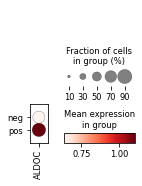

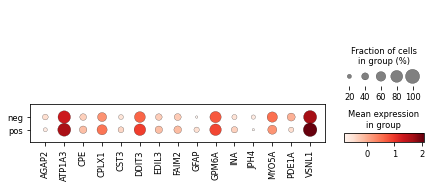

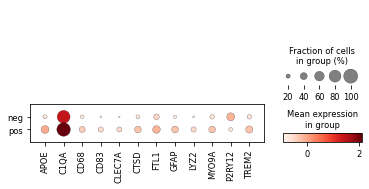

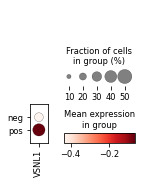

In [40]:
# inputSamples={'d13':['disease13'],'d8':['disease8'],'disease':['disease13','disease8'],'13':['disease13','control13'],'8':['disease8','control8'],'all':['disease13','control13','disease8','control8']}
inputSamples={'8':['disease8','control8']}

for inputName in inputSamples.keys():
    print(inputName)
    samples=inputSamples[inputName]
    savepath=os.path.join(desavepath,inputName)
    if not os.path.exists(savepath):
        os.mkdir(savepath)
    
    allInputnp=None
    allLabelsnp=None
    allCoordnp=None
    allcelltypebroad=None
    allSampleNames=None
    for c in np.unique(gaeclusterlabels):
        print(c)
        savepath_c=os.path.join(savepath,str(int(c)))
        if not os.path.exists(savepath_c):
            os.mkdir(savepath_c)
        for s in samples:
            cidx=gaeclusterlabels[sampleNames==s]==c
            if allInputnp is None:
                allInputnp=featureslist[s][cidx]
                allLabelsnp=labellist[s][cidx]
                allCoordnp=gaeCoord[sampleNames==s][cidx]
                allcelltypebroad=scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples[s],'top_level'][cidx]
                allSampleNames=np.repeat(s,np.sum(cidx))
            else:
                allInputnp=np.concatenate((allInputnp,featureslist[s][cidx]))
                allLabelsnp=np.concatenate((allLabelsnp,labellist[s][cidx]))
                allCoordnp=np.concatenate((allCoordnp,gaeCoord[sampleNames==s][cidx]))
                allcelltypebroad=np.concatenate((allcelltypebroad,scaleddata.obs.loc[scaleddata.obs['sample']==plot_samples[s],'top_level'][cidx]))
                allSampleNames=np.concatenate((allSampleNames,np.repeat(s,np.sum(cidx))))
#             print(allLabelsnp.shape)
        for ct in np.unique(allcelltypebroad):
            print(ct)
            savepath_ct=os.path.join(savepath_c,ct)
            ctidx=(allcelltypebroad==ct)
            labels_ct=allLabelsnp[ctidx]
            labels_ct_binary=np.where(labels_ct>0,'pos','neg')
            _,labelcounts=np.unique(labels_ct_binary,return_counts=True)
            if np.sum(labelcounts>minCell_DE)<labelcounts.size:
                continue
            print(labelcounts)
            de_singlesample(allInputnp[ctidx],labels_ct_binary,savepath_ct,feature_names,False)